#SISC

pip install ipykernel                           
python -m ipykernel install --user --name=SISC --display-name="SISC"

# NNNNNNNNNNNNNNNNNNNNNNNNNNNNNN

In [1]:
import os
import glob
import pandas as pd

# DD 폴더 안의 모든 CSV 파일 경로를 찾습니다.
data_folder = '/home/juwonkim/Pattern_Recognize/Data/Stock/1d'
csv_files = glob.glob(data_folder+'/*.csv')

# 빈 리스트를 준비하여 각 데이터프레임을 추가할 예정입니다.
dfs = []
dfs_volumn = []
dfs_rsi = []

# 각 CSV 파일을 읽어서 'close' 컬럼만 선택하여 처리합니다.
for file in csv_files:
    # 파일을 읽고 'date' 컬럼을 인덱스로 설정합니다.
    df = pd.read_csv(file, parse_dates=['Date'], index_col='Date')

    # 'close' 컬럼만 선택하고 컬럼 이름을 파일명에서 'csv' 확장자를 제거한 값으로 설정합니다.
    column_name = os.path.basename(file).replace('.csv', '')
    df_close = df[['Close']].rename(columns={'Close': column_name})
    df_volume = df[['Volume']].rename(columns={'Volume': column_name})
    df_rsi = df[['RSI']].rename(columns={'RSI': column_name})

    # 리스트에 데이터프레임을 추가합니다.
    dfs.append(df_close)
    dfs_volumn.append(df_volume)
    dfs_rsi.append(df_rsi)


# 모든 데이터프레임을 하나로 합칩니다.
df_combined = pd.concat(dfs, axis=1)
df_combined.index.name = 'index'
df_combined_volumn = pd.concat(dfs_volumn, axis=1)
df_combined_volumn.index.name = 'index'
df_combined_rsi = pd.concat(dfs_rsi, axis=1)
df_combined_rsi.index.name = 'index'

In [2]:
import pandas as pd

data_folder = '/home/juwonkim/Pattern_Recognize/Data/Stock/1d'
csv_files = glob.glob(data_folder+'/*.csv')

for file in csv_files:
    # 파일을 읽고 'date' 컬럼을 인덱스로 설정합니다.
    df = pd.read_csv(file, parse_dates=['Date'], index_col='Date')

c_10_18_22_30_BTC
[array([  6613. ,   6527.3,   6586.7, ..., 104090. , 102860. , 104160. ])]


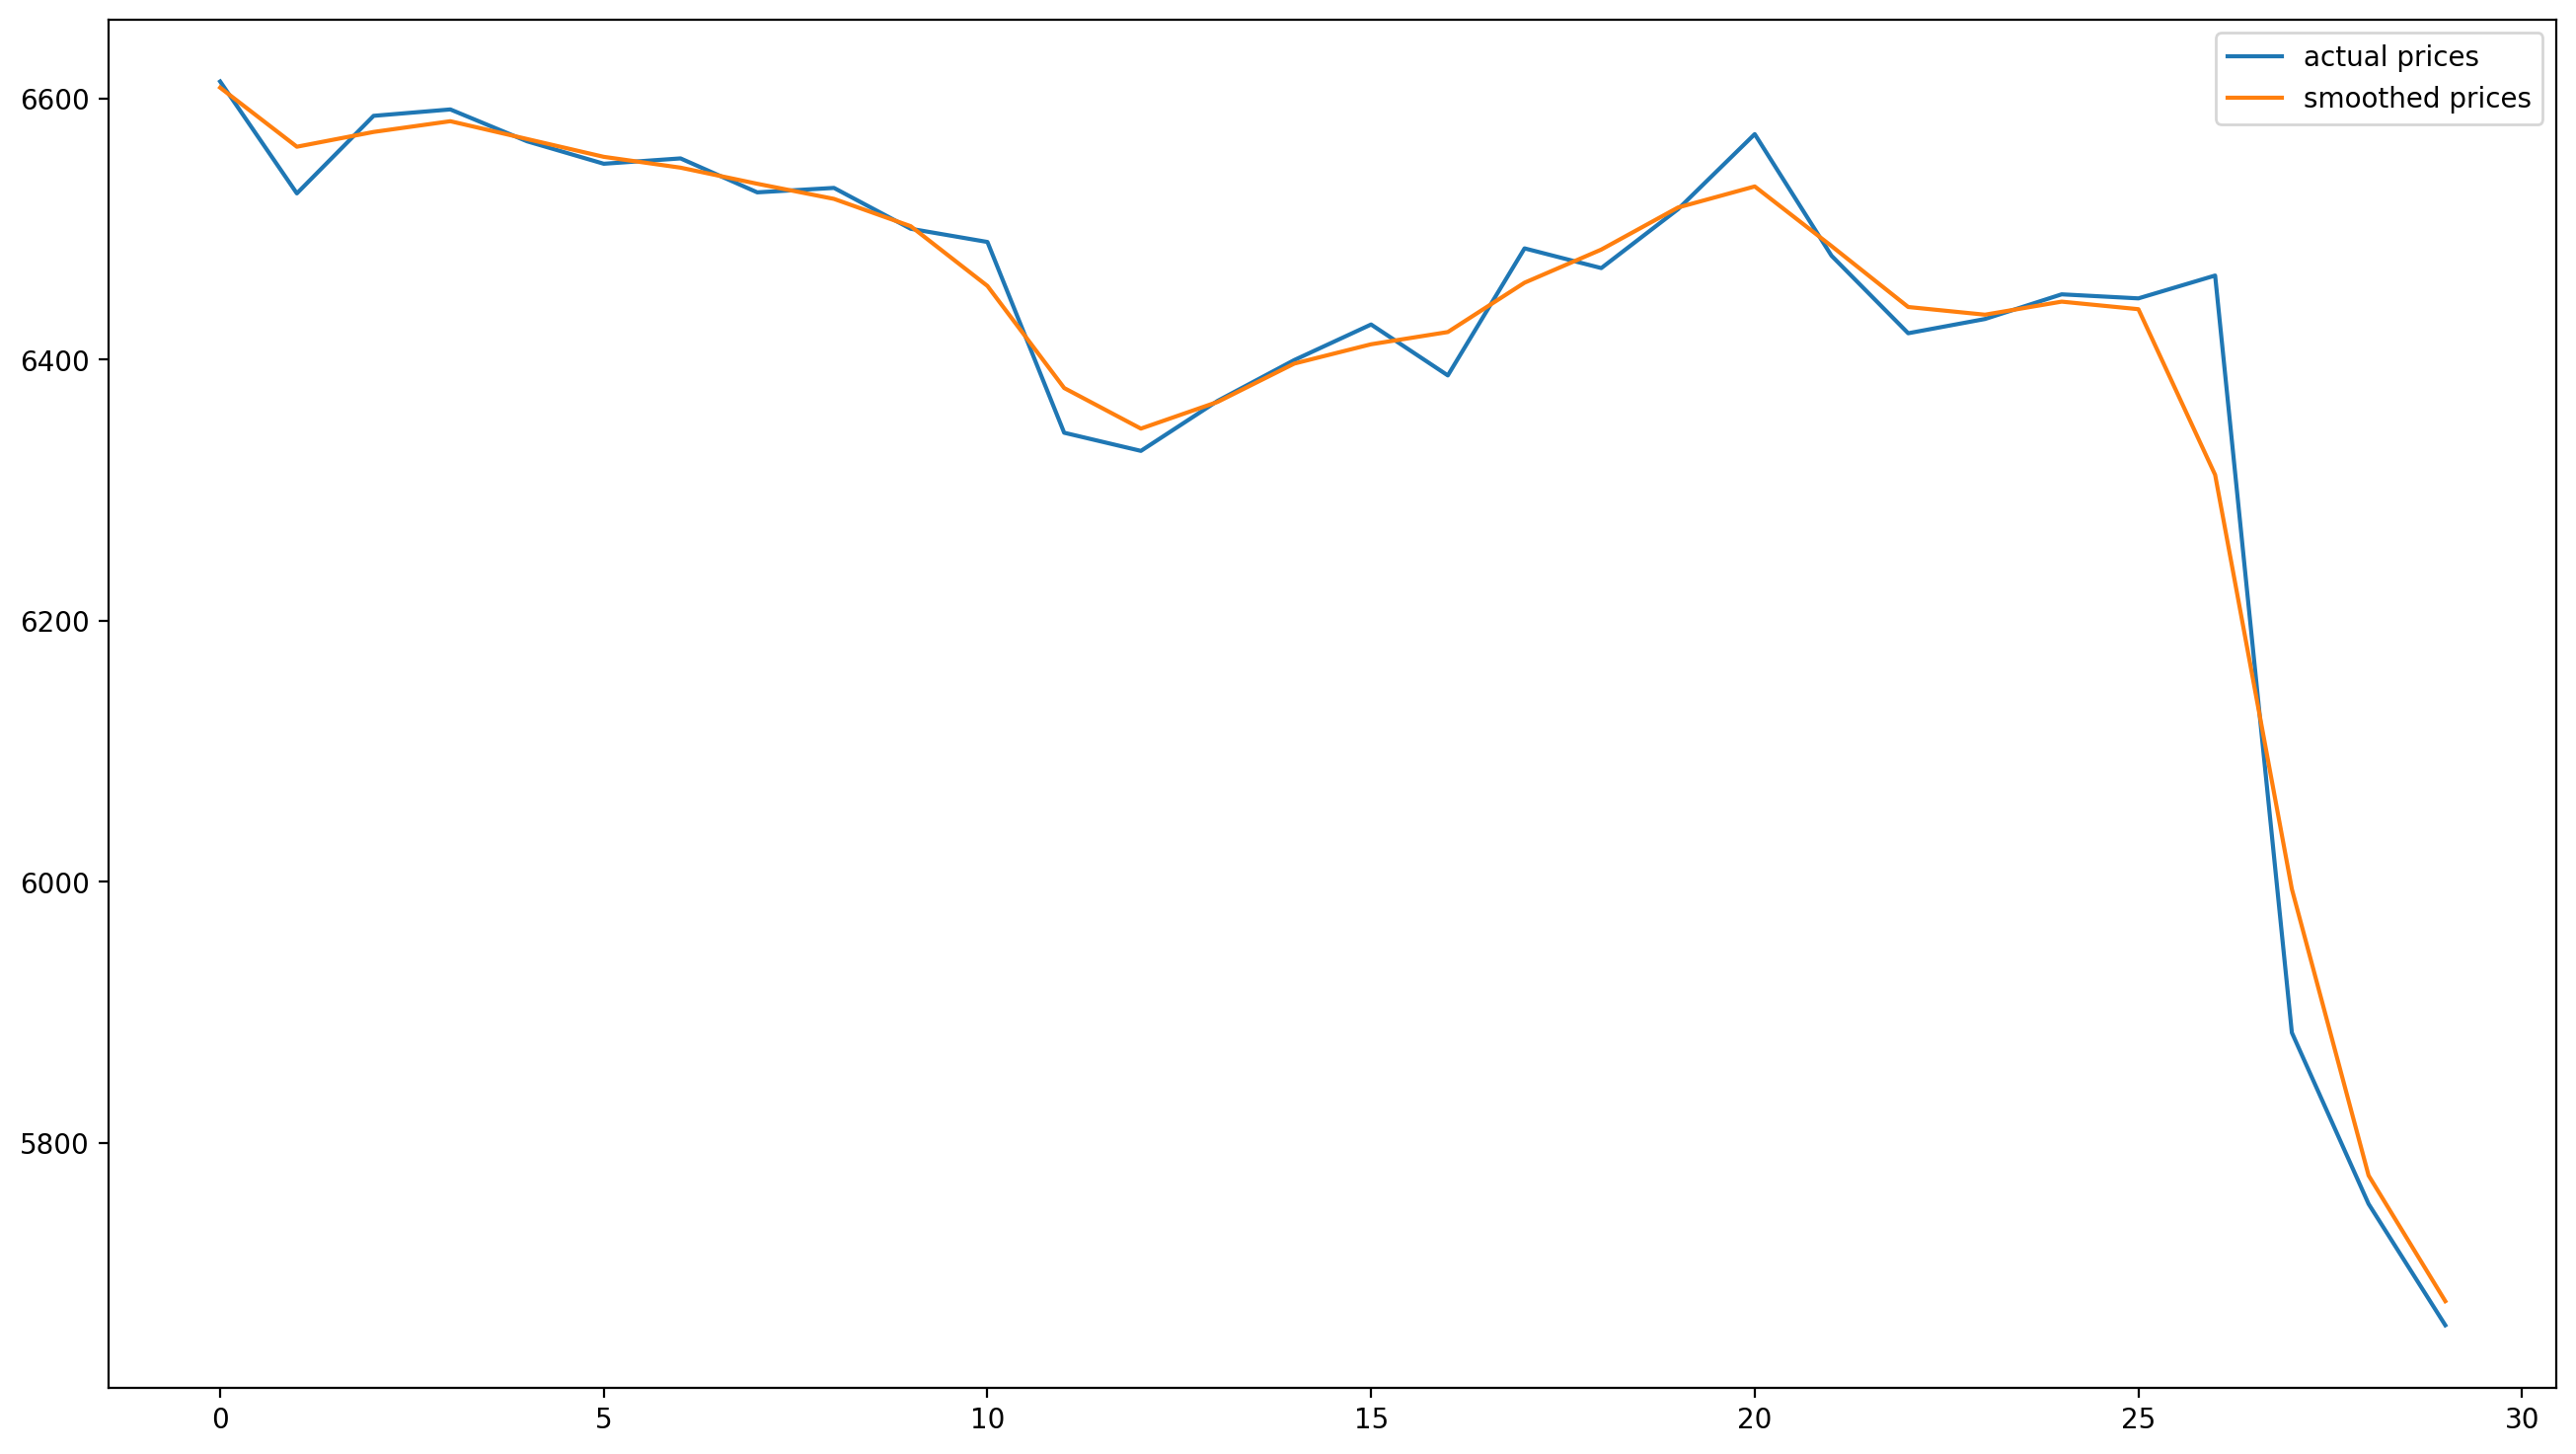

In [3]:
import pickle 
from statsmodels.nonparametric.kernel_regression import KernelReg
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pandas as pd


# data & hyperparameter 조절 
data_name = 'BTC'
data = pd.read_csv(f'/home/juwonkim/Pattern_Recognize/Data/BTC/{data_name}.csv')
data = data.drop(columns=['v', 'RSI', 'MA5', 'MA20', 'MA50', 'MA200']).tail(2400) #수정

n_clusters = 10
l_min = 18
l_max = 22
dist_thre = 1.50
clus_thre = 30
dataname = f'c_{n_clusters}_{l_min}_{l_max}_{clus_thre}_{data_name}' #수정
print(dataname)

# hyperparameter 조절 end 
data = data.reset_index(drop=True)
#data = data.iloc[::-1].reset_index(drop=True)
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 200
warnings.simplefilter(action='ignore', category=FutureWarning)
data['close'].iloc[:30].plot()

#kernel 추가
kr = KernelReg([data['close'].values], [data['close'].index.values], var_type='c', bw=np.full((1, 1), 0.8))
print([data['close'].values])
f = kr.fit([data['close'].index.values])
smooth_prices= pd.Series(data=f[0], index=data.index)
data['close'] = smooth_prices 
smooth_prices.iloc[:30].plot()
#end

plt.legend(['actual prices', 'smoothed prices'])

In [4]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler
import torch
torch.set_default_dtype(torch.float)
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle

# from models.utils_recognition import *
from utils.utils_clustering import *
from utils.load_data import *
from models.model_params import *
from models.pattern_recognition_module import *
from models.train_ftsdiffusion import *

import yfinance as yf
from concurrent.futures import ProcessPoolExecutor
from dtaidistance import dtw_ndim
from tslearn.barycenters import softdtw_barycenter, dtw_barycenter_averaging, dtw_barycenter_averaging_subgradient

In [5]:

res_path = '/home/juwonkim/Pattern_Recognize/SISC/res/'
min_dist_list = []


class SISC:
  def __init__(self, n_clusters, l_min=10, l_max=20, gamma=.5, dist_thre = 0.8, clus_thre = 3, trad_num = 0):
    self.n_clusters = n_clusters
    self.l_min = l_min
    self.l_max = l_max
    self.dist_thre = dist_thre
    self.clus_thre = clus_thre
    self.gamma = gamma
    self.T = None  # 데이터 시퀸스 길이
    self.centroids = None
    self.labels = None
    self.subsequences = None
    self.segmentation = None
    self.total_loss = np.inf
    self.min_loss = np.inf
    self.first_iter = True
    self.hist_loss = []
    self.converge = 0
    self.remain_idxs = []
    self.trad_num = trad_num


  def fit(self, series,
    max_iters,
    init_strategy='traditional',
    barycenter='dba',
    plot_progress=False,
    store_res=False, dataname=None):

    self.T = len(series)
    self.remain_idxs = np.arange(self.T-self.l_max+1)
    if self.first_iter:
      self.centroids = self.init_centroids(series, strategy=init_strategy)
      if plot_progress:
        self.plot_centroids(dataname, 0)
      self.first_iter = False

    # Start learning
    for iter in tqdm(range(max_iters)):
      curr_pos = 0
      new_subsequences = [] #각 부분 subsequence 시계열
      new_segmentation = [] #현재 position (index)
      new_labels = [] #어느 centroid에 해당하는지
      
      self.centroids = np.array([self._normalize_arr(x) for x in self.centroids])
      old_centroids = self.centroids

      # Greedy segmentation through the entire time series
      while curr_pos+self.l_min < self.T:
        #print('curr_pos: ', curr_pos)
        #현재 pos에서 centroid 집합에 속하는 subsequence가 있는지, 있으면 list에 추가 
        if curr_pos+self.l_max >= self.T:
          curr_seg, curr_seg_len, curr_seg_label = self.compute_optimal_segment(series[curr_pos:])
        else:
          curr_seg, curr_seg_len, curr_seg_label = self.compute_optimal_segment(series[curr_pos:curr_pos + self.l_max])
        if curr_seg is not None:
          new_subsequences.append(curr_seg)
          new_labels.append(curr_seg_label)
          new_segmentation.append(curr_pos)
        curr_pos += curr_seg_len

      new_subsequences = np.array(new_subsequences, dtype=object)
      new_labels = np.array(new_labels)
      new_segmentation = np.array(new_segmentation)
      new_segmentation, new_subsequences, new_labels, new_centroids, new_mean_loss, new_init_centroid = self.update_centroids(series, new_segmentation, new_subsequences, new_labels, iter, max_iters, barycenter)
      self.hist_loss.append(new_mean_loss)
      
      
      # Update results
      self.total_loss = new_mean_loss
      self.centroids = new_centroids
      self.labels = new_labels
      self.subsequences = new_subsequences
      self.segmentation = new_segmentation
      
      
      
      # Save results
      if store_res:
        self.save_results(new_mean_loss, dataname, init_strategy, barycenter)

      # Display progress
      print(f"-- Iter {iter+1} --")
      # 한 패턴 당 평균 loss
      #print(f"Total Mean Loss: {new_mean_loss}")
      if plot_progress:
        self.plot_centroids(dataname, iter+1)

      if new_init_centroid: 
        self.centroids = np.concatenate([self.centroids, new_init_centroid], axis=0)
        
      # Early-stop criteria. 패턴이 수렴할 경우 
      if self.stop_criteria(old_centroids):
        print(f"-- Converge and stop at iter {iter+1} --")
        break    
      
    plt.plot(self.hist_loss, marker='o')  # 점 표시 추가
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(len(self.hist_loss)))
    plt.grid(True)
    plt.show()
      

      # print(f"-- Terminate at iter {max_iters} --")

    ''' ~func: initialize the centroids at the begining '''
  def init_centroids(self, series, strategy='traditional'): #(n_cluster, length, n_variable)
    if strategy=='random_noise':
      # 각 클러스터 중심점을 정규분포에서 무작위로 샘플링
      return np.random.normal(0, 0.2, (self.n_clusters, self.l_max))
    elif strategy=='random_sample':
      # 입력 데이터 series에서 무작위로 클러스터의 개수만큼 부분 시퀀스를 선택하여 중심점으로 설정
      random_indices = np.random.choice(self.T, size=self.n_clusters, replace=False)
      return [series[idx:idx + self.l_max] for idx in random_indices]
    elif strategy=='kmeans++':
      # 중심점 간의 거리를 최대화하여 초기화
      #print('init_centroids')
      return self._kmeanspp_init(series)
    elif strategy=='traditional':
      # 중심점 간의 거리를 최대화하여 초기화
      #print('traditional')
      return self._traditional_init(series, self.trad_num)
    else:
      print("Invailid strategy for cluster initialization. Use K-Means++ instead.")
      return self._traditional_init(series, self.trad_num)


  def _traditional_init(self, series, trad_num):
    bundle_name= r'/home/juwonkim/Pattern_Recognize/SISC/Traditional_pattern/SP500_traditional-final'
    loaded_array = np.load(bundle_name + f"/centroid_array.npy")
    result = loaded_array[:trad_num]
    #result = result[:, :, :2]
    #with open(bundle_name + f"/centroids.csv", 'rb') as f:
    #  loaded_dict = pickle.load(f)
    #del loaded_dict['RTOP']
    #del loaded_dict['RBOT']
    #result = np.array([
    #    np.stack([v['close'], v['volume'], v['rsi']], axis=1) #수정 -------
    #    for v in loaded_dict.values()
    #])[:trad_num]
    
    if len(result) == 0:
      first_centroid = False
      return self._kmeanspp_init(series)
    else: 
      centroids = []
      first_centroid = False
      # iteratively add the next centroid probably far from the existings following k-means++
      while len(result) + len(centroids) < self.n_clusters:
        select_idx, self.remain_idxs, first_centroid = self._select_next_centroid(series,
                                                            self.remain_idxs, result,
                                                            first_centroid)
        seg = series[select_idx:select_idx+self.l_max]
        cluster_segments = self._normalize_arr(np.array(seg))
        centroids.append(cluster_segments)

      if centroids:
        result = np.concatenate([result, np.array(centroids)], axis=0)
      return result


  ''' ~util: k-means++ initialization '''
  def _kmeanspp_init(self, series):
    centroids = []
    first_centroid = True
    # iteratively add the next centroid probably far from the existings following k-means++
    while len(centroids)<self.n_clusters:
      select_idx, self.remain_idxs, first_centroid = self._select_next_centroid(series,
                                                           self.remain_idxs, centroids,
                                                           first_centroid)
      seg = series[select_idx:select_idx+self.l_max]
      cluster_segments = self._normalize_arr(np.array(seg))
      centroids.append(cluster_segments)
    return np.array(centroids, dtype=object)


  ''' ~util: select the next centroid following k-means++ '''
  def _select_next_centroid(self, series, remain_idxs, centroids, first_centroid):
    if first_centroid:
      weight = np.ones(len(remain_idxs))/len(remain_idxs)
      first_centroid = False
    else:
      weight = self._weight_next_centroid(series, remain_idxs, centroids)
    np.random.seed(42) 
    select_idx = np.random.choice(remain_idxs, p=weight)
    remain_idxs = np.delete(remain_idxs, np.where(remain_idxs==select_idx))
    return select_idx, remain_idxs, first_centroid #fix: 원래 코드에서 first_centroid가 true로 고정됨


  ''' ~util: compute the k-means++ probability of the next centroid '''
  def _weight_next_centroid(self, series, remain_idxs, centroids):
    weights = np.zeros(len(remain_idxs))
    for i, idx in enumerate(remain_idxs):
      seq = series[idx:idx+self.l_max]
      dist = [self._compute_scaled_dtw(seq, c) for c in centroids]
      weights[i] += min(dist) #fix: 잘못표기됨
    return weights/sum(weights)


  ''' ~util: compute the DTW distance with scaled magnitude '''
  def _compute_scaled_dtw(self, subse, centroid):
    subse = self._normalize_arr(subse) 
    return self._calculate_dtw(subse, centroid)


  def _normalize_arr(self, arr): #각 변수별 normalize
      scaler = MinMaxScaler(feature_range=(0, 1))

      # 데이터가 pandas DataFrame인 경우, numpy 배열로 변환
      if not isinstance(arr, np.ndarray):
          arr = arr.to_numpy()

      float_arr = arr.astype(float)
      # 데이터가 numpy ndarray이고 2차원인 경우
      if isinstance(float_arr, np.ndarray) and float_arr.ndim == 2:
          for i in range(float_arr.shape[1]):
              float_arr[:, i] = scaler.fit_transform(float_arr[:, i].reshape(-1, 1)).flatten()
      elif isinstance(float_arr, np.ndarray) and float_arr.ndim == 1:  # 데이터가 1차원 numpy 배열인 경우
          float_arr = scaler.fit_transform(float_arr.reshape(-1, 1))
      else:
          raise TypeError("Input must be a pandas DataFrame or a numpy ndarray.")
      return float_arr        #(변수 개수, subsequence 시계열 길이), 2차원


  def _calculate_dtw_parallel(self, stock1, stock2, parts=1):
    '''
    part_length = len(stock1) // parts
    results = []

    with ProcessPoolExecutor() as executor:
        futures = [
            executor.submit(self._calculate_dtw, stock1[i*part_length:(i+1)*part_length], stock2[i*part_length:(i+1)*part_length])
            for i in range(parts)
        ]
        results = [f.result() for f in futures]

    total_distance = sum(results)  # 이 예제에서는 간단히 결과를 합산합니다.
    return total_distance
    '''
    return self._calculate_dtw(stock1, stock2)

  def _calculate_dtw(self, stock1, stock2):
    """주어진 시계열 데이터에 대한 DTW 거리를 계산합니다."""
    distance = dtw_ndim.distance(stock1, stock2)
    return distance



  ''' ~util: find the possible segnments in a given sequence in length of l_max '''
  def _possible_segments(self, sequence, norm=True):
    #print('sequence in possible_segment: ', type(sequence), sequence.shape) #dataframe type, (length=20, 변수 수=3)
    if norm:
      #print('norm 하기')
      subseqs = [self._normalize_arr(sequence[:l]) for l in range(self.l_min, self.l_max+1)]
      #print('subseqs: ', subseqs) #shape: (max-min+1, length, n_variable)
    else:
      subseqs = [sequence[:l] for l in range(self.l_min, self.l_max+1)]
    return np.array(subseqs, dtype=object)

  ''' ~util: find the centroid with the minimum DTW distance '''
  def _compute_nearest_dtw(self, subsequence):
    distances = []
    for i, centroid in enumerate(self.centroids):
      distance = self._compute_scaled_dtw(subsequence, centroid)
      distances.append(distance)
    return min(np.array(distances)), int(np.argmin(np.array(distances)))

  def _new_centroid_compute_nearest_dtw(self, subsequence, centroid):
    distances = []
    distance = self._compute_scaled_dtw(subsequence, centroid)
    distances.append(distance)
    return min(np.array(distances)), int(np.argmin(np.array(distances)))
  
  def new_centroid_compute_optimal_segment(self, sequence, centroid):
      subsequences = self._possible_segments(sequence, norm=True) #shape: (max-min+1, length, n_variable)
      min_dist_label_pairs = np.array([self._new_centroid_compute_nearest_dtw(seq, centroid) for seq in subsequences]) #((2,2), (3,2), (4,2), (5,2))
      dist_column = min_dist_label_pairs[:, 0]
      min_sum = np.min(dist_column)
      min_dist_pos = np.argmin(dist_column)
      min_dist_list.append(min_sum)
      if min_sum < self.dist_thre:
        seq_optimal = subsequences[min_dist_pos]
        l_optimal = 5
        return seq_optimal, int(l_optimal)
      else:
        return None, 5

  def compute_optimal_segment(self, sequence):
    #norm=True: norm 해야한다는 말
    #_possible_segments() 가능한 길이의 subsequence를 모두 return. 각 변수별로 0-1 normalize 된 상태
    subsequences = self._possible_segments(sequence, norm=True) #shape: (max-min+1, length, n_variable)
    min_dist_label_pairs = np.array([self._compute_nearest_dtw(seq) for seq in subsequences]) #((2,2), (3,2), (4,2), (5,2))
    dist_column = min_dist_label_pairs[:, 0]
    min_sum = np.min(dist_column)
    min_dist_pos = np.argmin(dist_column)
    min_dist_list.append(min_sum)
    
    if min_sum < self.dist_thre:
      seq_optimal = subsequences[min_dist_pos]
      l_optimal = 5
      label_optimal = min_dist_label_pairs[min_dist_pos, 1]
      return seq_optimal, int(l_optimal), int(label_optimal)
    else:
      #print('no matching')
      # 매칭되는 centroid가 없을 경우 3 만큼 curr_pos 이동
      return None, 5, 0


  ''' ~func: update the centroids given the new segmented subsequences and labels '''
  def update_centroids(self, series, segmentation, subsequences, labels, iter, max_iters, barycenter='dba'):
    new_centroids = []
    filtered_indices = []
    new_init_centroid = []
    total_loss = 0.0

    for i in range(self.n_clusters):
      cluster_segments = subsequences[labels==i]
      #print(len(cluster_segments))
      if len(cluster_segments) >= self.clus_thre: # hyperparameter n_subsuquence가 thresh를 넘지 않는 cluster center 삭제
        centroid = self._compute_centroid(cluster_segments, barycenter)
        centroid = self._normalize_arr(centroid)
        new_centroids.append(centroid)
        inner_mean_loss = self._compute_inner_loss(cluster_segments, centroid)
        total_loss += inner_mean_loss
        
        condition = labels == i
        
        if np.any(condition):
          indices = np.where(condition)[0]    
          filtered_indices.extend(indices)
    #print('filtered_indices: ', filtered_indices)
    segmentation = segmentation[filtered_indices]
    subsequences = subsequences[filtered_indices]
    labels = labels[filtered_indices]

    #print('before cluster num: ', len(new_centroids))
    if iter+1 < max_iters: # 마지막 iter에는 15개 이상 subse가 있지 않은 경우 cluster 없애기
      if len(new_centroids) == 0:  #fix: centroid가 하나도 만들어지지 않았을 경우
        print('kmean++ 쓰임')
        new_centroids.extend(self.init_centroids(series, strategy='kmeans++'))
      else:
        init_new_centr = self.n_clusters - len(new_centroids)
        #print('init_new_centr: ', init_new_centr)
        for i in range(init_new_centr):  # fix 모자란 cluster 개수만큼 cluster centroid initalize
          select_idx, self.remain_idxs, _ = self._select_next_centroid(series,
                                                              self.remain_idxs, new_centroids,
                                                              first_centroid=False)
          seg = series[select_idx:select_idx+self.l_max]
          cluster_segments = self._normalize_arr(np.array(seg))
          new_init_centroid.append(cluster_segments)
          #기존의 centroid는 다른 subsequence들의 평균이기 때문에 제거할 idx 없음

    if not new_centroids:
      total_loss = -np.inf
    else:
      total_loss /= len(new_centroids)
    return segmentation, subsequences, labels, np.array(new_centroids, dtype=object), total_loss / len(new_centroids), new_init_centroid



  ''' ~util: normalize the segments into the standard scale in magnitude '''
  def _normalize_segments(self, segments):
    segments_norm = []
    for seg in segments:
        max_values = np.max(seg, axis=0)
        min_values = np.min(seg, axis=0)
        seg_norm = (seg - min_values) / (max_values - min_values)
        segments_norm.append(seg_norm)
    return np.array(segments_norm, dtype=object)



  ''' ~util: compute centroid given the subsequences with a cluster '''
  def _compute_centroid(self, subsequences, barycenter='dba'):
    # Use DTW
    if barycenter=='dba':
      return dtw_barycenter_averaging(subsequences, barycenter_size=self.l_max, tol=1e-5)
    # Use soft-DTW
    elif barycenter=='softdtw':
      subseq_lengths = [len(subseq) for subseq in subsequences]
      index_maxlen = np.argmax(subseq_lengths)
      interp_f = interp1d(np.linspace(0, 1, len(subsequences[index_maxlen])), subsequences[index_maxlen])
      subsequences[index_maxlen] = interp_f(np.linspace(0, 1, self.l_max))
      return softdtw_barycenter(subsequences, gamma=self.gamma, tol=1e-5)



  ''' ~util: compute the inner cluster loss '''
  def _compute_inner_loss(self, subsequences, centroid):
    inner_loss = 0.0
    for subseq in subsequences:
      inner_loss += self._compute_scaled_dtw(subseq, centroid)
    return inner_loss / len(subsequences)



  '''~func: early stop criteria'''
  def stop_criteria(self, old_centroids, epsilon=5e-1):
    #if len(new_centroids) != self.n_clusters:
    #  return False
    #각 centroid의 순서는 새로 매칭됨
    for new, old in zip(self.centroids, old_centroids):
      dtw = self._compute_scaled_dtw(new, old)
      print('dtw: ', dtw)
      #print(epsilon * np.sqrt(self.centroids.shape[2]))
      if dtw > (epsilon * np.sqrt(self.centroids.shape[2])):
        self.converge = 0
        #print('self.converge: ', self.converge)
        return False
    if self.converge == 0:
      self.converge = 1
      print('self.converge: ', self.converge)
      return False
    return True
  


  ''' ~func: plot the centroids '''
  def plot_centroids(self, dataname='BTC', iter=0):
    n_rows = 1
    n_cols = len(self.centroids)
    #print('n_cols: ', n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows * 0.7))
    
    # axs가 단일 객체이면 리스트로 변환, 배열이면 평탄화
    if n_cols == 1:
        axs = [axs]
        
    for i, centroid in enumerate(self.centroids):
      axs[i].plot(centroid)
      axs[i].get_xaxis().set_visible(False)
      axs[i].get_yaxis().set_visible(False)

    plt.tight_layout()  # 그래프 간 겹침 방지
    #plt.savefig(f'/home/juwonkim/Pattern_Recognize/SISC/pic/plot_{iter}_{dataname}.png')  # 파일로 저장
    plt.close()
    #plt.show()


    ''' ~func: save the results '''
  def save_results(self, new_mean_loss, dataname, init_strategy, barycenter):
    if new_mean_loss<=self.min_loss:
      self.min_loss = new_mean_loss
      dict_init = {'traditional': 'trad',
                   'kmeans++': 'kmpp',
                  'random_sample': 'rs',
                  'random_noise': 'rn',
                  'reference':'ref'}
      filename = f"sisc_{dataname}_k{self.n_clusters}_l{self.l_min}-{self.l_max}_{barycenter[:4]}_{dict_init[init_strategy]}"
      
      unique_vals = sorted(set(self.labels))
      mapping = {val: i for i, val in enumerate(unique_vals)}
      new_label = [mapping[a] for a in self.labels]

      with open(res_path + filename +'_centroids.pkl', 'wb') as file:
        pickle.dump(self.centroids, file)
      with open(res_path + filename +'_labels.pkl', 'wb') as file:
        pickle.dump(new_label, file)
      with open(res_path + filename +'_subsequences.pkl', 'wb') as file:
        pickle.dump(self.subsequences, file)
      with open(res_path + filename +'_segmentation.pkl', 'wb') as file:
        pickle.dump(self.segmentation, file)
      with open(res_path + filename +'_MinMeanLoss.txt', 'wb') as file:
        pickle.dump(self.min_loss, file)  

# 변수에 따른 패턴 수/유사도/평균 dtw

# 이용하는 전통패턴 수에 따른 패턴 수/유사도/평균 dtw 비교

# framework 2를 위해 전체 비트코인 시계열에서 패턴 추출 4693 

dataname:  Framework2_XOM_cvr_clus8_newtrad4


  0%|          | 0/300 [00:00<?, ?it/s]

-- Iter 1 --
dtw:  1.048880591830022
-- Iter 2 --
dtw:  0.9337808006157925
-- Iter 3 --
dtw:  0.713528262435618
dtw:  0.8457561860340379
dtw:  0.3803189399421271
dtw:  0.7227239665550681
dtw:  0.6789071243701233
dtw:  0.5621053462599871
dtw:  0.5925181274668572
dtw:  1.3272548288655661
-- Iter 4 --
dtw:  0.641551627887651
dtw:  0.5781789277357748
dtw:  0.3290669662640236
dtw:  0.6501527354170408
dtw:  0.28996962884483907
dtw:  0.32527996976242396
dtw:  0.5791785352158336
dtw:  1.593979967985475
-- Iter 5 --
dtw:  0.6969373908063072
dtw:  0.717604846145367
dtw:  0.11146716726632702
dtw:  0.4128300830219731
dtw:  0.5210107354865208
dtw:  0.44517854931261824
dtw:  0.7259999633450424
dtw:  1.1564335726323969
-- Iter 6 --
dtw:  0.8942359703509536
-- Iter 7 --
dtw:  0.5867686825843801
dtw:  0.9646195091098285
-- Iter 8 --
dtw:  0.765507110492547
dtw:  0.41460078482615814
dtw:  0.7511817162629717
dtw:  0.7662563905929615
dtw:  0.693717515802444
dtw:  0.6965385126265079
dtw:  1.265797989499099

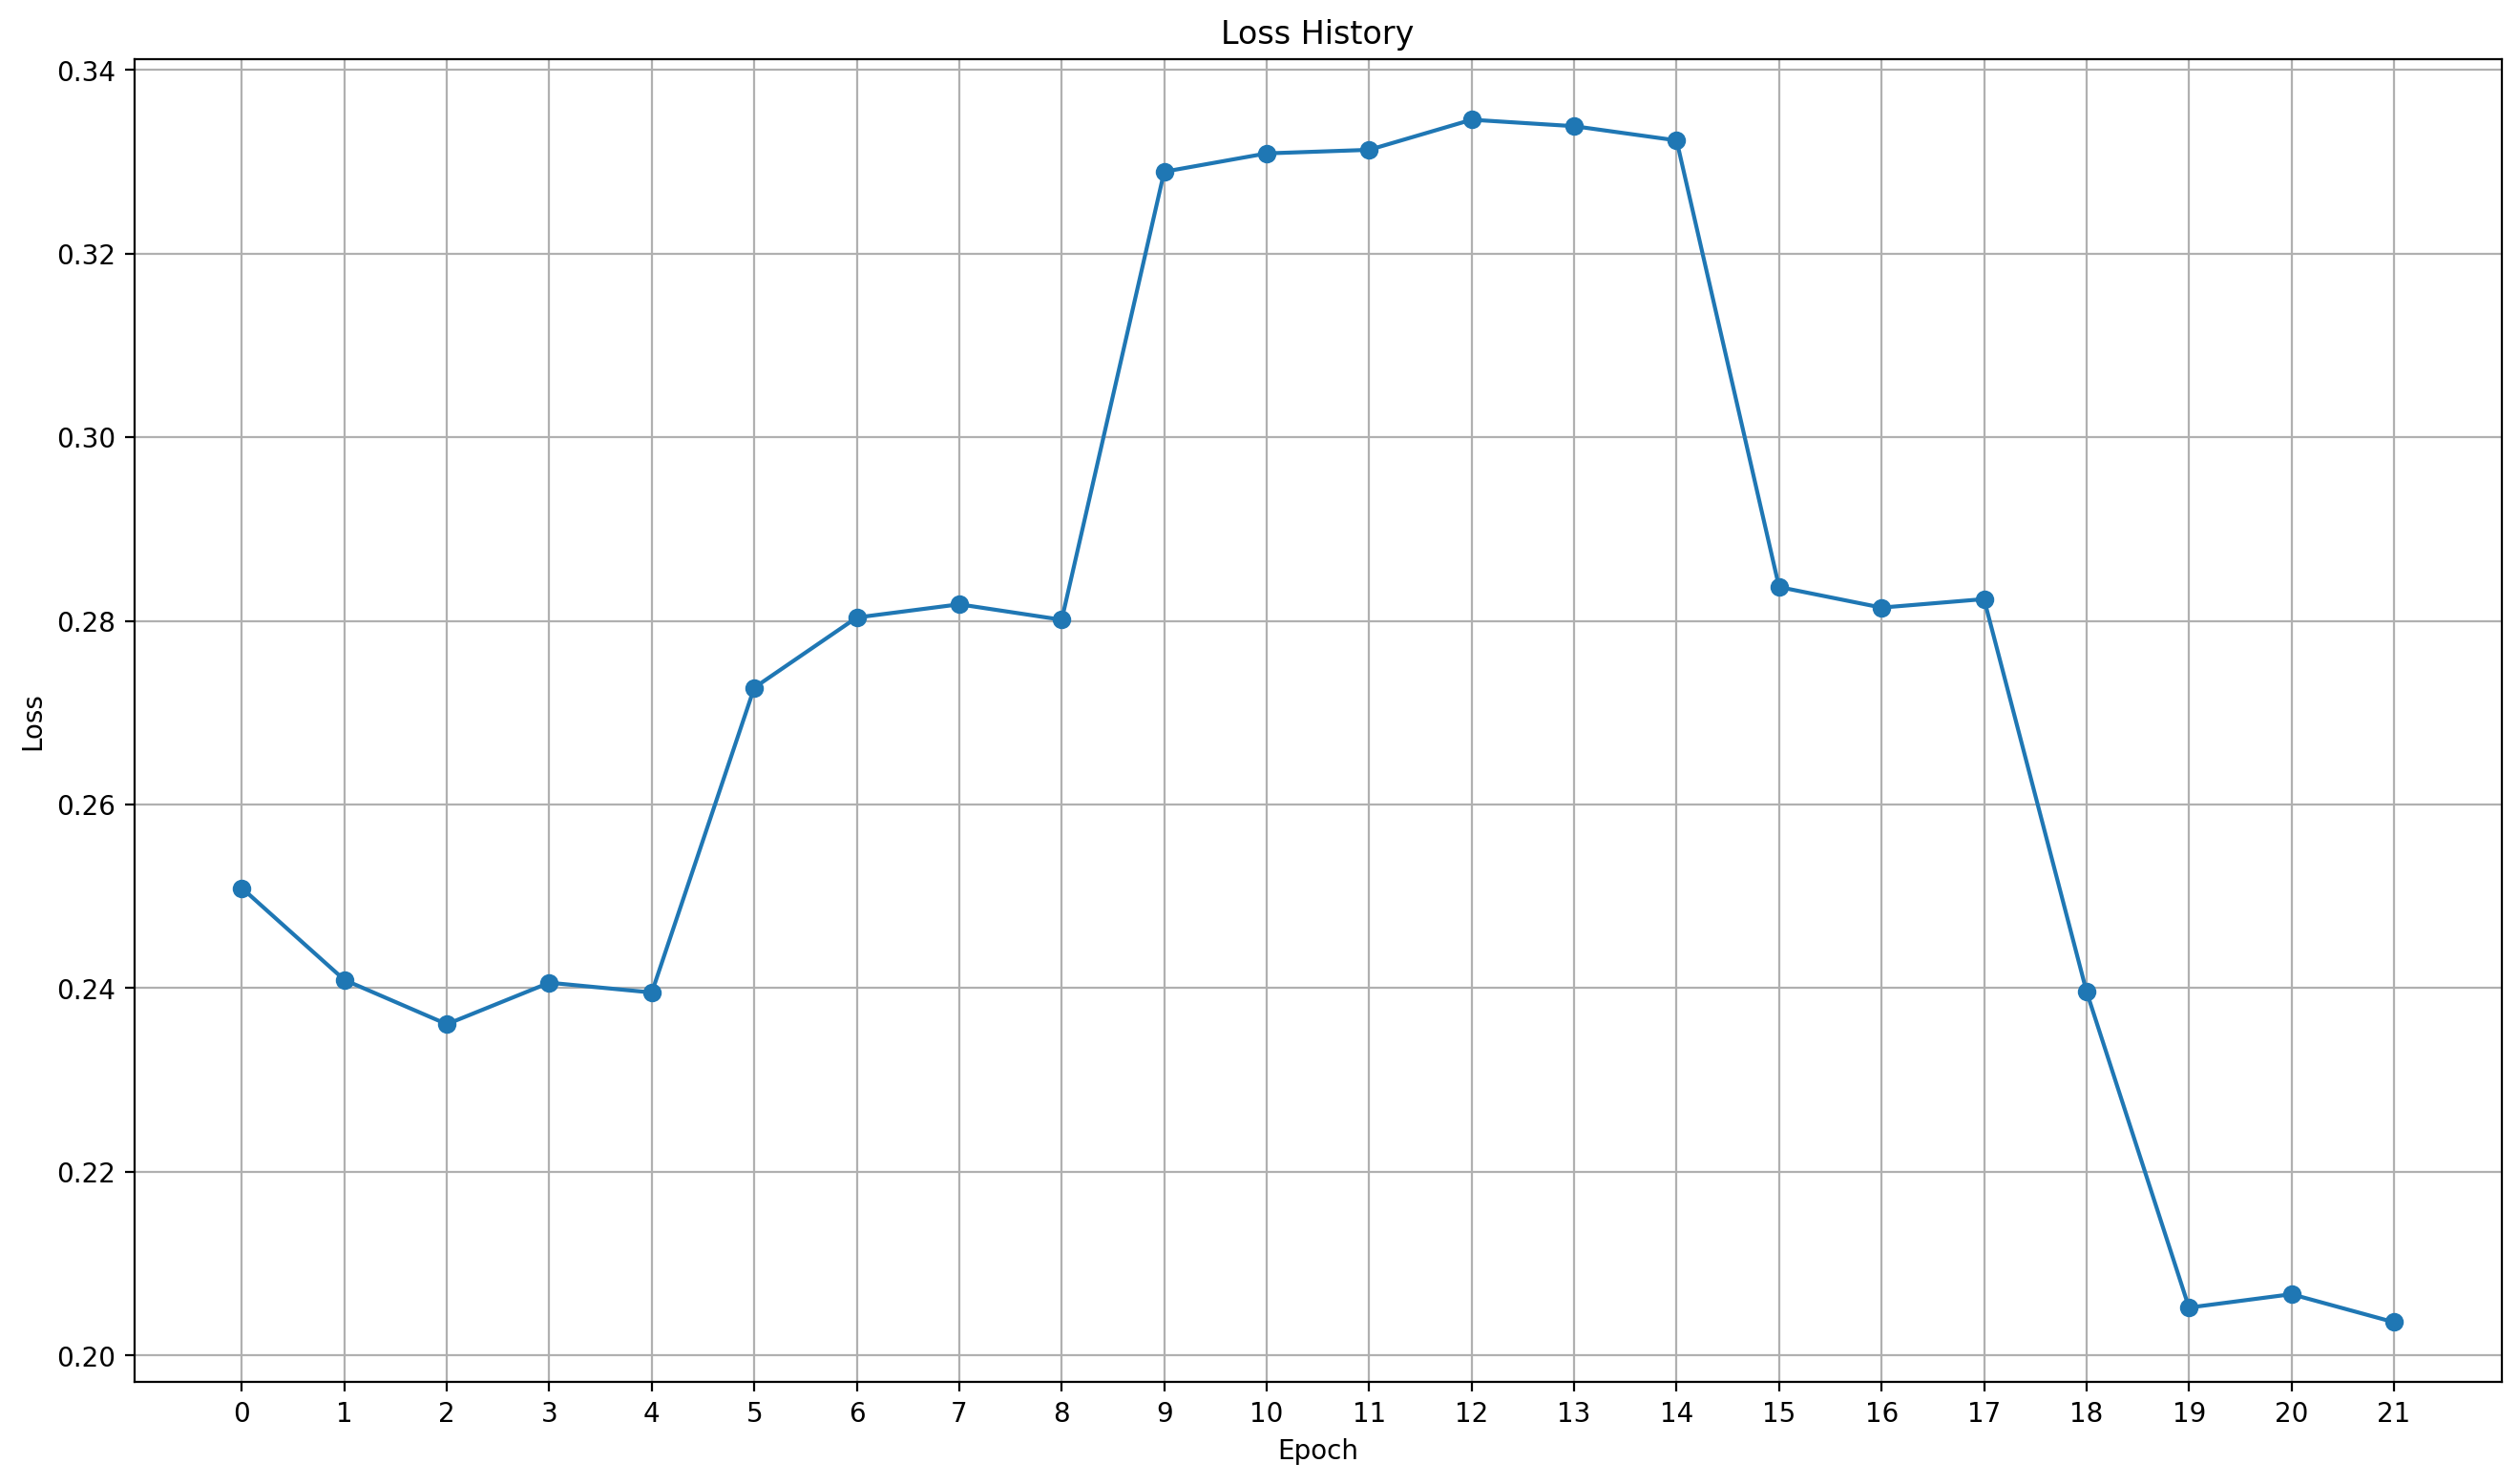

In [6]:
# BTC / close + volume + rsi / trad_num = 6

data_name = 'XOM' # BTC, AAPL, XOM, BRKb
data = pd.read_csv(f'/home/juwonkim/Pattern_Recognize/Data/{data_name}/{data_name}_train.csv')

#hyperparameter 
drop_cols = ['date', 'MA5', 'MA20', 'MA50', 'MA200', 'OT']
data = data.drop(columns=[col for col in drop_cols if col in data.columns])
n_clusters = 8
l_min = 18
l_max = 22
dist_thre = 2.3 #수정 1.33, 1.88, 2.3
clus_thre = 40 #40, 60
variable = 'cvr'  #수정
trad_num = 4
dataname = f'Framework2_{data_name}_{variable}_clus{n_clusters}_newtrad{trad_num}' 
print('dataname: ', dataname)

#-----------------------
kr = KernelReg([data['close'].values], [data['close'].index.values], var_type='c', bw=np.full((1, 1), 0.8))
f = kr.fit([data['close'].index.values])
smooth_prices= pd.Series(data=f[0], index=data.index)
data['close'] = smooth_prices 


sisc = SISC(n_clusters=n_clusters, l_min=l_min, l_max=l_max, gamma=0.8, 
            dist_thre=dist_thre, clus_thre=clus_thre, trad_num=trad_num)
sisc.fit(series=data,
        max_iters=300,
        init_strategy='traditional', # 기존의 전통을 initial centroid로 설정
        barycenter='dba',
        plot_progress=True, 
        store_res=True, dataname=dataname)
        

In [8]:
#저장된 centroid, label, loss 등등 부르기

from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pickle


#variable = 'cvr'
init = 'trad' # kmpp, trad
trad = '_4' # init가 kmeans인 경우 빈 string

if init == 'kmpp':
    trad = ''

base_path = f'/home/juwonkim/Pattern_Recognize/SISC/res/{data_name}'
file_name = f'sisc_Framework2_{data_name}_{variable}_clus{n_clusters}_newtrad{trad_num}_k{n_clusters}_l18-22_dba_trad'
#file_name = f'sisc_{variable}_{n_cluster}_18_22_30_BTC{trad}_k{n_cluster}_l18-22_dba_{init}' 


file_path = f'{base_path}/{file_name}_centroids.pkl'
with open(file_path, 'rb') as f:
    centroid = pickle.load(f)
    print('centroids shape: ', centroid.shape)
    
file_path = f'{base_path}/{file_name}_labels.pkl'
with open(file_path, 'rb') as f:
    label = pickle.load(f)
    
file_path = f'{base_path}/{file_name}_subsequences.pkl'
with open(file_path, 'rb') as f:
    subsequence = pickle.load(f)
        

centroids shape:  (8, 22, 3)


In [9]:
# 유사한 class 하나로 합치기

import numpy as np
from dtaidistance import dtw
from tslearn.barycenters import dtw_barycenter_averaging


def normalize_centroids_minmax(centroid_list):
    # 복사본 생성 (원본 유지)
    normalized = np.copy(centroid_list)

    for i in range(normalized.shape[0]):  # 각 centroid마다
        for j in range(normalized.shape[2]):  # 각 변수마다
            series = normalized[i, :, j]
            min_val = np.min(series)
            max_val = np.max(series)
            
            # 분모가 0이 되는 경우 방지 (max == min인 경우 0으로 채움)
            if max_val - min_val == 0:
                normalized[i, :, j] = 0
            else:
                normalized[i, :, j] = (series - min_val) / (max_val - min_val)
    
    return normalized


def update_centroids_and_labels(centroid, label, subsequence, threshold=0.735):
    centroid = normalize_centroids_minmax(centroid)
    num_classes = centroid.shape[0]
    n_variable = centroid.shape[2]
    print()
    #current_centroids = list(range(num_classes))  # 현재 centroid 번호
    centroid_map = {i: i for i in range(num_classes)}  # 삭제된 centroid의 label 매핑

    # 1. 유사한 centroid 쌍 찾고 제거 (DTW < threshold)
    to_remove = set()
    for i in range(num_classes):
        for j in range(i + 1, num_classes):
            if i in to_remove or j in to_remove:
                continue
            
            d = dtw_ndim.distance(centroid[i], centroid[j])
            #print(d)
            if d < (threshold * np.sqrt(n_variable)):
                print(f"DTW({i}, {j}) = {d:.3f} < {threshold * n_variable}, removing {j}")
                to_remove.add(j)
                centroid_map[j] = i

    # 2. label 업데이트
    new_label = np.array([centroid_map.get(l, l) for l in label])

    # 3. 남은 centroid 번호 리스트
    remaining_classes = sorted(set(new_label))
    new_centroid = []

    # 4. centroid 재계산
    for c in remaining_classes:
        idxs = np.where(new_label == c)[0]
        if len(idxs) == 0:
            continue
        seqs = subsequence[idxs]
        new_c = dtw_barycenter_averaging(seqs, barycenter_size=22, tol=1e-5)
        new_centroid.append(new_c)

    new_centroid = np.array(new_centroid)

    return new_centroid, new_label

new_centroid, new_label = update_centroids_and_labels(centroid, label, subsequence)

with open(f'{base_path}/{file_name}_centroids_new.pkl', 'wb') as file:
    pickle.dump(new_centroid, file)
with open(f'{base_path}/{file_name}_labels_new.pkl', 'wb') as file:
    pickle.dump(new_label, file)

centroids shape:  (8, 22, 3)
변경 후


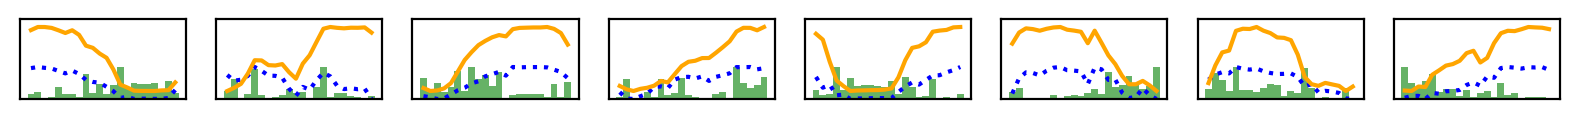

변경 전


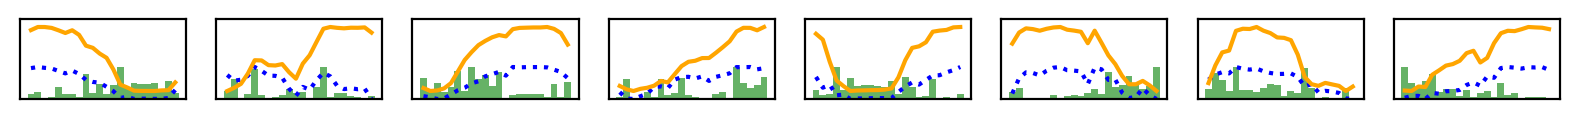

In [10]:
#centroid 시각화

file_path = f'{base_path}/{file_name}_centroids_new.pkl'
with open(file_path, 'rb') as f:
    new_centroid = pickle.load(f)
    print('centroids shape: ', new_centroid.shape)
    
    
def plot_c(centroid, variable):
    color_map = {
        'c': 'orange',
        'v': 'green',
        'r': 'blue',
        'm': 'purple',
    }

    range_map = {
        'c': (0.1, 0.9),
        'v': (0, 0.4),
        'r': (0.0, 0.4),
        'm': (0.1, 0.9),
    }

    colors = [color_map[var] for var in variable]
    ranges = [range_map[var] for var in variable]

    num_vars = len(variable)
    n_rows = 1
    n_cols = len(centroid)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows * 0.7))

    if n_cols == 1:
        axs = [axs]

    for i, center in enumerate(centroid):
        if center.shape[1] != num_vars:
            raise ValueError(f"Centroid[{i}] has {center.shape[1]} variables, but 'variable' has {num_vars}.")

        for j in reversed(range(center.shape[1])):  # 시계열 역순으로 그리기
            series = center[:, j]
            min_val, max_val = np.min(series), np.max(series)
            if max_val - min_val == 0:
                norm_series = np.zeros_like(series)
            else:
                norm_series = (series - min_val) / (max_val - min_val)

            low, high = ranges[j]
            scaled_series = norm_series * (high - low) + low

            if variable[j] == 'v':
                axs[i].bar(
                    np.arange(len(scaled_series)),
                    scaled_series,
                    color=colors[j],
                    width=1.0,
                    alpha=0.6
                )
            else:
                linestyle = ':' if variable[j] == 'r' else '-'
                axs[i].plot(
                    scaled_series,
                    color=colors[j],
                    alpha=1,
                    linestyle=linestyle
                )
        
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)
        axs[i].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

print('변경 후')
plot_c(new_centroid, variable)

print('변경 전')
plot_c(centroid, variable)

In [11]:
#저장된 centroid, label, loss 등등 부르기

from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pickle


file_path = f'{base_path}/{file_name}_centroids_new.pkl'
with open(file_path, 'rb') as f:
    centroid = pickle.load(f)
    print('centroids shape: ', centroid.shape)
    #print('centroids: ', centroid)
    
file_path = f'{base_path}/{file_name}_labels_new.pkl'
with open(file_path, 'rb') as f:
    label = pickle.load(f)
    print(Counter(label))
    print('label total num: ', len(label))
    print('평균 sub 패턴 수: ', len(label) / len(set(label)))
    #print('labels: ', label)
    
file_path = f'{base_path}/{file_name}_segmentation.pkl'
with open(file_path, 'rb') as f:
    data = pickle.load(f)
    print('segmentation total num: ', len(data))
    #print('segmentation: ', data)
    
file_path = f'{base_path}/{file_name}_subsequences.pkl'
with open(file_path, 'rb') as f:
    subsequence = pickle.load(f)
    print('subsequences shape: ', data.shape)
    #print('subsequences: ', data)
    

file_path = f'{base_path}/{file_name}_MinMeanLoss.txt'
with open(file_path, "rb") as f:  # binary 모드로 열기
    data = pickle.load(f)
    print('loss: ', data)
        

centroids shape:  (8, 22, 3)
Counter({np.int64(0): 143, np.int64(4): 116, np.int64(2): 87, np.int64(5): 73, np.int64(6): 70, np.int64(3): 66, np.int64(1): 55, np.int64(7): 46})
label total num:  656
평균 sub 패턴 수:  82.0
segmentation total num:  656
subsequences shape:  (656,)
loss:  0.20362178154219013


In [ ]:
!nvidia-smi

Sat May 17 08:51:31 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A6000               On  | 00000000:01:00.0 Off |                  Off |
| 44%   73C    P2             298W / 300W |  43616MiB / 49140MiB |    100%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import pickle

# 피클 파일 열기
with open('/home/juwonkim/Pattern_Recognize/ShapeNet/shapenet/result/BTC_shapelet_label.pkl', 'rb') as f:
    data = pickle.load(f)
data

[np.int64(0), np.int64(3), np.int64(1), np.int64(5), np.int64(4)]

In [ ]:
import pickle

# 피클 파일 열기
with open(f'/home/juwonkim/Pattern_Recognize/ShapeNet/shapenet/result/{data_name}_shapelet.pkl', 'rb') as f:
    data = pickle.load(f)
data[1].shape

(3, 60)

In [ ]:
import pickle

# 피클 파일 열기
with open('/home/juwonkim/Pattern_Recognize/ShapeNet/shapenet/result/BTC_utility_sort_index.pkl', 'rb') as f:
    data = pickle.load(f)
data

array([2, 4, 3, 1, 0])

In [ ]:
import pickle

# 피클 파일 열기
with open('/home/juwonkim/Pattern_Recognize/ShapeNet/shapenet/result/BTC_test.pkl', 'rb') as f:
    data = pickle.load(f)
data.shape

(94, 3, 100)

In [ ]:
import pickle

# 피클 파일 열기
with open('/home/juwonkim/Pattern_Recognize/ShapeNet/shapenet/result/BTC_test_label.pkl', 'rb') as f:
    data = pickle.load(f)
data

array([0, 4, 4, 1, 4, 3, 1, 5, 0, 5, 2, 4, 5, 5, 4, 2, 4, 2, 3, 5, 3, 2,
       3, 2, 0, 4, 2, 0, 2, 1, 0, 4, 2, 3, 4, 1, 0, 3, 2, 1, 1, 2, 2, 1,
       2, 5, 3, 4, 0, 0, 3, 3, 3, 4, 0, 1, 4, 1, 2, 5, 1, 5, 4, 4, 4, 3,
       0, 5, 2, 4, 5, 3, 4, 3, 3, 1, 4, 1, 3, 4, 3, 2, 3, 0, 5, 0, 4, 5,
       1, 3, 2, 4, 0, 1])